In [22]:

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import col, lit, concat_ws

from sklearn.metrics import classification_report
import requests
from warcio import ArchiveIterator
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
import yfinance as yf
import boto3
import botocore
import random
import sys 
#PARAMETERS

numcrawlsforrun = 1
batch_size_max = sys.maxsize -1
num_records_percrawl = 100 #number of recors to attempt to extract from each crawl
ticker = 'SPY'
#read in financewordlist.csv into the list
wordlist = pd.read_csv('./sentdat/topics.csv', header=None)[0].tolist()
wordlist.extend(yf.Ticker(ticker).info['longName'].split())


#start spark sesssion
spark = SparkSession.builder.appName("sentimentanalysis")\
.config("spark.jars.packages","com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.3")\
.getOrCreate()
# .config("spark.driver.memory","8G")\
# .config("spark.driver.maxResultSize", "2G")\
# .config("spark.jars", "file:///home/ubuntu/sparknlp.jar")\
# .config("spark.driver.extraClassPath", "file:///home/ubuntu/sparknlp.jar")\
# .config("spark.executor.extraClassPath", "file:///home/ubuntu/sparknlp.jar")\

###GETTING WARC FILE NAMES FROM S3, GRABBING A RANDOM SAMPLE OF THEM
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('commoncrawl')
warcs = []
for object in my_bucket.objects.filter(Prefix='crawl-data/CC-NEWS/'):
    if object.key.endswith('.warc.gz'):
        warcs.append(object.key)

#choose 100 random warcs
randomwarcs = random.sample(warcs, numcrawlsforrun)

for index, warc in enumerate(randomwarcs):
    randomwarcs[index] = 'https://data.commoncrawl.org/' + warc

#function to convert time from commoncrawl format to y-m-d
def convert_header_date(date):
    return time.strftime('%Y-%m-%d', time.strptime(date, '%Y-%m-%dT%H:%M:%SZ'))


#obtaining stock data from yahoo finance from 2019 to current date.
currentdate = time.strftime("%Y-%m-%d")
stockdata = yf.download(ticker, start='2010-01-01', end=currentdate)['Adj Close']

#creating scehma to store text and prices
data = StructType([\
  StructField("text", StringType(), True),
    StructField("price", StringType(), True),  
]
)



22/12/14 15:03:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
[*********************100%***********************]  1 of 1 completed


In [9]:
def contains_stock(plaintext, stklist=wordlist): 
    try:
        for stk in stklist:
            if plaintext.find(stk) != -1:
                return True
        return False
    except:
        raise Exception("issue with wordlist")

In [16]:
warcs[-5:]

['crawl-data/CC-NEWS/2022/12/CC-NEWS-20221214121625-02976.warc.gz',
 'crawl-data/CC-NEWS/2022/12/CC-NEWS-20221214130439-02977.warc.gz',
 'crawl-data/CC-NEWS/2022/12/CC-NEWS-20221214135217-02978.warc.gz',
 'crawl-data/CC-NEWS/2022/12/CC-NEWS-20221214143721-02979.warc.gz',
 'crawl-data/CC-NEWS/2022/12/CC-NEWS-20221214152206-02980.warc.gz']

In [34]:

float(stockdata[date])

326.48553466796875

In [12]:
response = requests.get('https://data.commoncrawl.org/'+warcs[-1], stream=True)

In [15]:
response.raw.read(1)

b'\x08'

In [23]:
# creating the main rdd to store the data
df = spark.createDataFrame(spark.sparkContext.emptyRDD(), data)
list_of_rows_batch = []
rows_batch_len = 0
recordsfetched = 0
failures = 0

for warc_url in randomwarcs:
    response = requests.get(warc_url, stream=True)
    if response.ok!=True:
        raise Exception("Error downloading WARC file")
    records = ArchiveIterator(response.raw, arc2warc=True)
    #what this should do is write each record's plaintexxt to a csv file
    for record in records:
        if record.rec_type == 'response':
            try: 
                html = record.content_stream().read() .decode('utf-8')
                plaintext = BeautifulSoup(html, 'lxml').get_text()
                plaintext = re.sub(r'\s+', ' ', plaintext)
                plaintext = re.sub(r'[^a-zA-Z0-9\s]', '', plaintext).lower()

                #obtains plaintext from the html
                if detect(plaintext) == 'en' and len(plaintext) > 150:  #TODO add classifier here later to ensure its a financial article
                    date = record.rec_headers.get_header('WARC-Date')
                    date = convert_header_date(date)
                    # append the plaintext and price to the batch
                    if date in stockdata.index:
                        list_of_rows_batch.append({'text':plaintext, 'price':float(stockdata[date])})
                        recordsfetched += 1
                        rows_batch_len += 1
                    else:
                        print('date not in stockdata',date)
                        #likely a weekend or holiday, so we will just skip the entire warc
                        break
                else:
                    recordsfetched += 1                          
            except:
                recordsfetched += 1  # because if the entire warc file is not in english or wrong date, we still want to move on to the next one
                failures += 1
                #print("attempt record: ", record.rec_headers.get_header('WARC-Target-URI'), " failed")
                pass

        if rows_batch_len >= batch_size_max: 
            batchdf = spark.createDataFrame(list_of_rows_batch, data)
            print("union started")
            df = df.union(batchdf)
            print("union done")
            print(df.count())
            rows_batch_len = 0
            list_of_rows_batch = []
        if recordsfetched >= num_records_percrawl:
            recordsfetched = 0
            print("warc done")
            break

    #finishing up for the last batch in it wasn't full and num batches wasnt maxed out.
if rows_batch_len > 0:
    print(rows_batch_len)
    batchdf = spark.createDataFrame(list_of_rows_batch, data)
    df = df.union(batchdf)
    print("size of data: ", df.count())
    rows_batch_len = 0
print("done")
print("failures: ", failures)
   

warc done
42


size of data:  42
done
failures:  2


In [ ]:
def drop_nonfinance_articles(df):
  model = PipelineModel.load("./models/model_dl")
  df = model.transform(df)
  df = df.withColumn('finance', df['financial_model_pred.result'].getItem(0).cast('float'))
  df = df.filter(df['finance'] == 1.0)
  return df

model = PipelineModel.load("./models/model_dl")



In [3]:
import math
ratio_com_yfin = 1
math.floor(df.count()*ratio_com_yfin)

65

In [ ]:
#NOW THE DATA IS IN THE SPARK DATAFRAME. wE ARE TRAINING CLASSIFICATION MODEL ON FINANCIAL NEWS DATA and commoncrawl data
#which has been sorted by keywords to ensure it is not financial news.
#credit to the financial news articles at https://www.kaggle.com/datasets/jeet2016/us-financial-news-articles
#read in all the json files into a dataframe from 2018_01_112b52537b67659ad3609a234388c50a

articles = spark.read.json('./data/2018_01_112b52537b67659ad3609a234388c50a/').limit(df.count()*ratio_com_yfin)


In [20]:

articles = articles.withColumn('price', lit(0))
articles = articles.withColumn('financial', lit(1))
cols = articles.columns
for item in ['text', 'price', 'financial']:
    cols.remove(item)
articles = articles.drop(*cols)


In [21]:
#write articles to a parquet file
articles.write.parquet('./articlespar.parquet')

In [5]:
articles = spark.read.parquet('./articlespar.parquet').limit(df.count()*ratio_com_yfin)


In [6]:


df = df.withColumn('financial', lit(0))
df = df.union(articles)

#split the data into training and testing
train, test = df.randomSplit([0.8, 0.2], seed=3204123)

In [7]:


# preprocess the text data
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

normalizer = Normalizer()\
    .setInputCols(["token"])\
    .setOutputCol("normalized")\
    .setLowercase(True)

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained("lemma_antbnc")\
    .setInputCols(["cleanTokens"])\
    .setOutputCol("lemma")

word_embeddings = BertEmbeddings\
    .pretrained('bert_base_cased', 'en') \
    .setInputCols(["document",'lemma'])\
    .setOutputCol("embeddings")\

# word_embeddings = AlbertEmbeddings.pretrained('albert_base_uncased', 'en') \ #lighter eight bert embeddings
#     .setInputCols(["document",'lemma'])\
#     .setOutputCol("embeddings")\

# https://nlp.johnsnowlabs.com/docs/en/transformers#bertsentenceembeddings? better for sentence embeddings for later models, this one words is better
#https://nlp.johnsnowlabs.com/docs/en/transformers#debertaembeddings
#lots of transfoemrs to choose from for later tasks, for this one lightweight bert might be the best
embeddingsSentence = SentenceEmbeddings()\
    .setInputCols(["document", "embeddings"])\
    .setOutputCol("sentence_embeddings")\
    .setPoolingStrategy("AVERAGE")

classifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("financial_model_pred")\
    .setLabelColumn("financial")\
    .setMaxEpochs(5)\
        .setEnableOutputLogs(True)\
    .setLr(0.001)\

DLpipeline = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stopwords_cleaner,
        lemma,
        word_embeddings,
        embeddingsSentence,
        classifierdl
    ])


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]
bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[ | ]bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
Download done! Loading the resource.
[ — ]

2022-12-13 16:58:18.771184: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK!]


In [8]:
DLpipelineModel = DLpipeline.fit(train)
DLpipelineModel.save("dl_model")
# model = PipelineModel.load("dl_model")
print("done training")
test_predict = DLpipelineModel.transform(test)


22/12/13 17:07:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 149740 ms exceeds timeout 120000 ms
22/12/13 17:07:04 WARN SparkContext: Killing executors is not supported by current scheduler.


2022-12-13 17:07:37.579647: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/228e2899eeed_classifier_dl5646696838384616029
2022-12-13 17:07:37.643124: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-12-13 17:07:37.643189: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /tmp/228e2899eeed_classifier_dl5646696838384616029
2022-12-13 17:07:38.078349: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-12-13 17:07:39.619684: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/228e2899eeed_classifier_dl5646696838384616029
2022-12-13 17:07:39.780919: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 2201279 microsecon

Training started - epochs: 5 - learning_rate: 0.001 - batch_size: 64 - training_examples: 103 - classes: 2
Epoch 1/5 - 0.43s - loss: 1.7357066 - acc: 0.96594554 - batches: 2
Epoch 2/5 - 0.02s - loss: 1.2325315 - acc: 1.0 - batches: 2
Epoch 3/5 - 0.02s - loss: 1.2279463 - acc: 1.0 - batches: 2
Epoch 4/5 - 0.02s - loss: 1.1629893 - acc: 1.0 - batches: 2
Epoch 5/5 - 0.02s - loss: 1.086009 - acc: 1.0 - batches: 2
done training


In [14]:

results = test_predict.select('text','price', 'financial','financial_model_pred.result')
results = results.withColumn('result', results['result'].getItem(0).cast('float'))

# # results = results.withColumn('result', results['result'].cast('float'))
# print("done predicting, here are results on the test set")
#print(classification_report(results.select('financial').collect(), results.select('result').collect()), 'green')

#https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/jupyter/transformers/HuggingFace%20in%20Spark%20NLP%20-%20BERT.ipynb
#https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32
#can get bert from there, then create a piepline that uses the bert model to get embeddings, then use the embeddings to train a classifier
#then we conver this to a script, upload to emr and get a large scale model.

In [15]:
results.show(30)

In [53]:
#NEED TO PROCESS THE BAG OF BIG WORDS, dont need to run this every time
#http://mpqa.cs.pitt.edu/lexicons/subj_lexicon/ from this source for academic sentiment analysis
#copy sentiment-big.tff to a txt file
#then use this to create a csv file

sentimentprocess = pd.read_csv('./sentdat/sentiment-big.txt', sep=' ', header=None)
#remove all columns except 5 and 0
sentimentprocess = sentimentprocess[[2,5]]

#strip type= from column 0
sentimentprocess[2] = sentimentprocess[2].str.replace('word1=', '')
#strip priorpolarity= from column 5
sentimentprocess[5] = sentimentprocess[5].str.replace('priorpolarity=', '')
sentimentprocess.head(10)
#save to csv
sentimentprocess.to_csv('./sentdat/sentiment-big.csv', index=False)

In [54]:


print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

#model = NerDLModel.pretrained('ner_dl')

# doc_df=documentAssembler.transform(df)
# doc_df.show()
#has been transformed into a text, vector column
#https://nlp.johnsnowlabs.com/2022/09/06/finclf_bert_sentiment_en.html

# sort data by language? use different models for different languages?
#train own model for english with amazon reviews?

document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

# normalizer = Normalizer() \
#     .setInputCols(['token']) \
#     .setOutputCol('normalized') \

lemmatizer = Lemmatizer()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')\
  .setDictionary("./sentdat/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
#! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt -P /tmp
SentimentDetector = sentiment.SentimentDetector() \
    .setInputCols(['lemma', 'sentence'])\
    .setOutputCol('sentiment_score')\
    .setDictionary('./sentdat/sentiment-big.csv', ',')\

pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    lemmatizer,
    SentimentDetector
])







Spark NLP version 4.2.3
Apache Spark version: 3.3.1


In [ ]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sentiment-corpus/default-sentiment-dict.txt -P ./sentdat 


In [ ]:
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt -P ./sentdat

In [55]:
newdf = pipeline.fit(df).transform(df)
#getting a new df with sentiment score

In [56]:


newdf = newdf.withColumn("sentiment_score", concat_ws(",", "sentiment_score.result"))
newdf.show(2)


+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+
|                text|             price|            document|            sentence|               token|               lemma|sentiment_score|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+
| Chicago Med Seas...|394.69000244140625|[{document, 0, 14...|[{document, 1, 64...|[{token, 1, 7, Ch...|[{token, 1, 7, Ch...|       positive|
| Roberto Guilherm...|394.69000244140625|[{document, 0, 60...|[{document, 1, 13...|[{token, 1, 7, Ro...|[{token, 1, 7, Ro...|       positive|
+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+---------------+
only showing top 2 rows



In [57]:
print("positives", newdf.filter(col('sentiment_score') == 'positive').count())
print("negatives", newdf.filter(col('sentiment_score') == 'negative').count())


positives 77


negatives 23


In [21]:
spark.stop()

In [3]:
'''
Usuage:
scp this file, requirements.txt, a model called model_dl inside models folder, and sentdat folder to the cluster, and the dockerfile and
training_fin_classfier.py to the cluster. 
Could scp everything but will take far longer, just scp everything but the parquet and make an empty parquet dir on the cluster.
sudo build/run the dockerfile with -e PYTHONFILETORUN=./sentiment_run.py, arguments go before the image name in run cmd
make an empty dir called articlespar.parquet
if running locally just build and run dockerfile but with additional arguments of (-e AWS_ACCESS_KEY_ID= -e AWS_SECRET_ACCESS_KEY=)
'''

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import col, lit, concat_ws

from sklearn.metrics import classification_report
import requests
from warcio import ArchiveIterator
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
import yfinance as yf
import boto3
import botocore
import random
import sys 
import numpy as np
#PARAMETERS
path_dl_model = './models/model_dl'
batch_size_max = sys.maxsize -1
num_records_percrawl = 60 #number of recors to attempt to extract from each crawl
ticker = 'SPY'
list_of_dates_to_process = []
#read in financewordlist.csv into the list
wordlist = pd.read_csv('./sentdat/topics.csv', header=None)[0].tolist()
wordlist.extend(yf.Ticker(ticker).info['longName'].split())
number_warcs_to_analyze = 2 #number of warcs to perform sentiment analysis on, goes from most reccent to farther back onse

###GETTING WARC FILE NAMES FROM S3, GRABBING A RANDOM SAMPLE OF THEM
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('commoncrawl')
warcs = []
for object in my_bucket.objects.filter(Prefix='crawl-data/CC-NEWS/'):
    if object.key.endswith('.warc.gz'):
        warcs.append(object.key)

warcs = warcs[-55:-52]

for index, warc in enumerate(warcs):
    warcs[index] = 'https://data.commoncrawl.org/' + warc

#function to convert time from commoncrawl format to y-m-d
def convert_header_date(date):
    return time.strftime('%Y-%m-%d', time.strptime(date, '%Y-%m-%dT%H:%M:%SZ'))


#obtaining stock data from yahoo finance from 2019 to current date.
currentdate = time.strftime("%Y-%m-%d")
stockdata = yf.download(ticker, start='2010-01-01', end=currentdate)['Adj Close']

#creating scehma to store text and prices
data = StructType([\
  StructField("text", StringType(), True),
    StructField("price", StringType(), True),
    StructField("date", StringType(), True)  
]
)


#function to drop non-finance articles
def drop_nonfinance_articles(df):
  model = PipelineModel.load(path_dl_model)
  df = model.transform(df)
  df = df.withColumn('finance', df['financial_model_pred.result'].getItem(0).cast('float'))
  df = df.filter(df['finance'] == 1.0)
  return df



# creating the main rdd to store the data
df = spark.createDataFrame(spark.sparkContext.emptyRDD(), data)
list_of_rows_batch = []
rows_batch_len = 0
recordsfetched = 0
failures = 0
datelist = []

for warc_url in warcs:
    response = requests.get(warc_url, stream=True)
    if response.ok!=True:
        raise Exception("Error downloading WARC file")
    records = ArchiveIterator(response.raw, arc2warc=True)
    #what this should do is write each record's plaintexxt to a csv file
    for record in records:
        if record.rec_type == 'response':
            try: 
                html = record.content_stream().read() .decode('utf-8')
                plaintext = BeautifulSoup(html, 'lxml').get_text()
                plaintext = re.sub(r'\s+', ' ', plaintext)
                plaintext = re.sub(r'[^a-zA-Z0-9\s]', '', plaintext).lower()

                #obtains plaintext from the html
                if detect(plaintext) == 'en' and len(plaintext) > 150:  
                    date = record.rec_headers.get_header('WARC-Date')
                    date = convert_header_date(date)
                    # append the plaintext and price to the batch
                    if date in stockdata.index:
                        datelist.append(date)
                        list_of_rows_batch.append({'text':plaintext, 'price':float(stockdata[date]), 'date':date})
                        recordsfetched += 1
                        rows_batch_len += 1
                    else:
                        print('date not in stockdata',date)
                        #likely a weekend or holiday, so we will just skip the entire warc
                        break
                else:
                    recordsfetched += 1                          
            except:
                recordsfetched += 1  # because if the entire warc file is not in english or wrong date, we still want to move on to the next one
                failures += 1
                #print("attempt record: ", record.rec_headers.get_header('WARC-Target-URI'), " failed")
                pass

        if rows_batch_len >= batch_size_max: 
            datelist = np.unique(datelist)
            batchdf = spark.createDataFrame(list_of_rows_batch, data)
            print("union started")
            df = df.union(batchdf)
            print("union done")
            print(df.count())
            rows_batch_len = 0
            list_of_rows_batch = []
        if recordsfetched >= num_records_percrawl:
            recordsfetched = 0
            print("warc done")
            break

    #finishing up for the last batch in it wasn't full and num batches wasnt maxed out.
if rows_batch_len > 0:
    datelist = np.unique(datelist)
    print(rows_batch_len)
    batchdf = spark.createDataFrame(list_of_rows_batch, data)
    df = df.union(batchdf)
    print("size of data: ", df.count())
    rows_batch_len = 0
print("done")
print("failures: ", failures)

###########READING IN THE DATA NOW DONE, STARTING TO PROCESS IT





[*********************100%***********************]  1 of 1 completed
warc done
warc done
warc done
99


size of data:  99
done
failures:  0


In [ ]:
#dropping non-finance articles
newdf = drop_nonfinance_articles(df)
#drop all columns but text price and date
cols = df.columns
for item in ['text', 'price', 'date']:
    cols.remove(item)
df = df.drop(*cols)

print("size of data after dropping non-finance articles: ", newdf.count())

In [4]:
df.show(4)

+--------------------+------------------+----------+
|                text|             price|      date|
+--------------------+------------------+----------+
|highrise homicide...|398.95001220703125|2022-12-12|
|cute red panda cu...|398.95001220703125|2022-12-12|
|cute red panda cu...|398.95001220703125|2022-12-12|
| millennials inhe...|398.95001220703125|2022-12-12|
+--------------------+------------------+----------+
only showing top 4 rows



In [6]:
document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

# normalizer = Normalizer() \
#     .setInputCols(['token']) \
#     .setOutputCol('normalized') \

lemmatizer = Lemmatizer()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')\
  .setDictionary("./sentdat/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
#! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/lemma-corpus-small/lemmas_small.txt -P /tmp
SentimentDetector = sentiment.SentimentDetector() \
    .setInputCols(['lemma', 'sentence'])\
    .setOutputCol('sentiment_score')\
    .setDictionary('./sentdat/sentiment-big.csv', ',')\

pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    lemmatizer,
    SentimentDetector
])

In [ ]:
datelist

In [ ]:
even_newerdf = pipeline.fit(newdf).transform(newdf)

In [8]:
even_newerdf = even_newerdf.withColumn("sentiment_score", concat_ws(",", "sentiment_score.result"))

In [ ]:
print("total positive and negatives: ")
print("positives", even_newerdf.filter(col('sentiment_score') == 'positive').count())
print("negatives", even_newerdf.filter(col('sentiment_score') == 'negative').count())

In [ ]:
sentscores = []
finacial_data = []
for date in datelist:
    print("date: ", date)
    positives = even_newerdf.filter(col('sentiment_score') == 'positive').filter(col('date') == date).count()
    negatives = even_newerdf.filter(col('sentiment_score') == 'negative').filter(col('date') == date).count()
    print("positives", positives)
    print("negatives", negatives)
    if negatives == 0:
        sentscores.append(positives)
    sentscores.append(positives/negatives)
    finacial_data.append(float(stockdata[date]))

import matplotlib.pyplot as plt
x = np.arange(len(finacial_data))
plt.plot(x, finacial_data)
plt.plot(x, sentscores)
plt.show()
plt.savefig('sentiment.png')

In [ ]:
df = pipeline.fit(df).transform(df)

df = df.withColumn("sentiment_score", concat_ws(",", "sentiment_score.result"))
print("total positive and negatives: ")
print("positives", df.filter(col('sentiment_score') == 'positive').count())
print("negatives", df.filter(col('sentiment_score') == 'negative').count())


date:  2022-12-12


positives 87
negatives 12


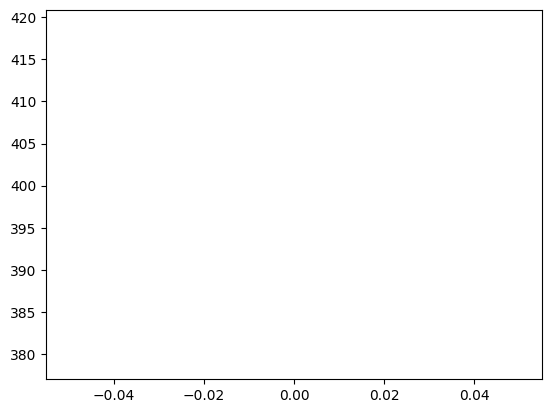

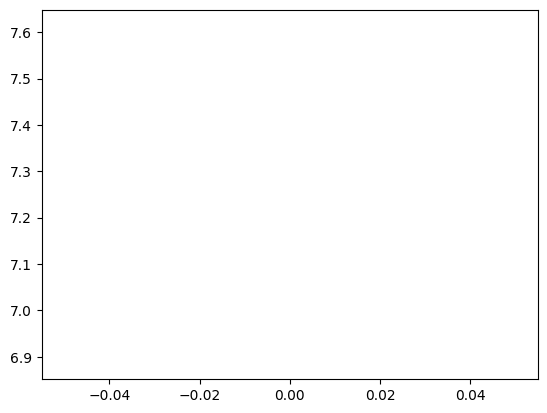

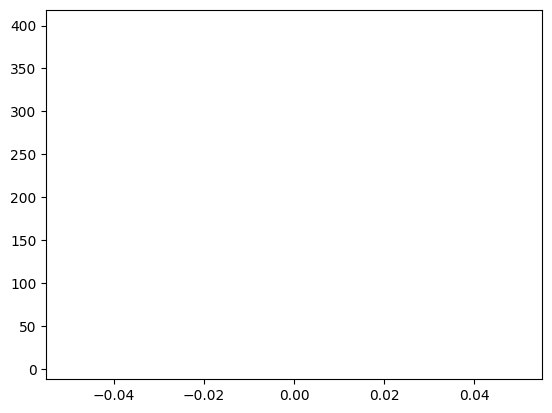

[7.25]
[398.95001220703125]
['2022-12-12']


<Figure size 640x480 with 0 Axes>

In [18]:



sentscores = []
finacial_data = []
for date in datelist:
    print("date: ", date)
    positives = df.filter(col('sentiment_score') == 'positive').filter(col('date') == date).count()
    negatives = df.filter(col('sentiment_score') == 'negative').filter(col('date') == date).count()
    print("positives", positives)
    print("negatives", negatives)
    if negatives == 0:
        sentscores.append(positives)
    sentscores.append(positives/negatives)
    finacial_data.append(float(stockdata[str(date)]))

import matplotlib.pyplot as plt
x = np.arange(len(finacial_data))
plt.plot(x, finacial_data)
plt.show()
plt.plot(x, sentscores)
plt.show()
plt.plot(x, finacial_data)
plt.plot(x, sentscores)
plt.show()
plt.savefig('sentiment.png')

print(sentscores)
print(finacial_data)
print(datelist)

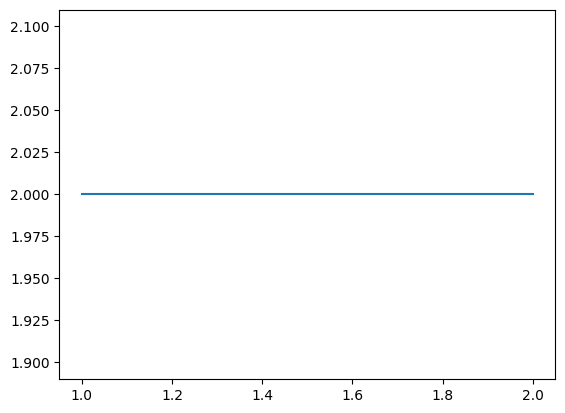

In [17]:
plt.plot([1,2],[2,2])